# Astroinformatics
## Class 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift
import itertools
from scipy.signal import butter, lfilter, freqz
import seaborn; seaborn.set()
import time
%matplotlib inline

## Fourier Transform

#### Fourier Transform of $h(t)$ and Inverse Fourier Transform:
$$ H(f) = \int_{-\infty}^{\infty}h(t)e^{-i2\pi ft}dt, \hspace{1cm} h(t) = \int_{-\infty}^{\infty}H(f)e^{2i\pi ft}df $$

The sign in the exponential is a convention, this one is from scipy and most engineering books. Also, the factor $1/(2\pi)$ is due to the change of variable $\omega = 2\pi f$

#### Discrete Fourier Transform:
Taking $h_{j}=h(t_{j})$ with $t_{j}=t_{0}+j\Delta t$, $j=0,1,...,(N-1)$ and $T=N \Delta t$
$$ H_{k}=\sum_{j=0}^{N-1}h_{j}e^{-i2\pi jk/N}, \hspace{1cm} h_{j}=\frac{1}{N}\sum_{k=0}^{N-1}H_{K}e^{i2\pi jk/N}$$

#### Aliasing
If $h(t)$ is {\bf  band  limited}, there is some resolution limit in $t$ space, $t_c = 1 / (2 f c)$, below which $h(t)$ appears smooth. According to the {\bf Nyquist sampling theorem} we can \emph{exactly} reconstruct $h(t)$ from evenly sampled data when
    $\Delta t \le t_c$ as:

$$ h(t) = \frac{\Delta t}{t_c} \sum_{-\infty}^{\infty} h_k \frac{ \sin[ 2 \pi f_c (t - k \Delta t)]}{2 \pi f_c (t - k \Delta t)} = \frac{\Delta t}{t_c} \sum_{-\infty}^{\infty} h_k sinc[2 \pi f_c (t - k \Delta t)] $$

#### Power Spectral Density
$$PSD(f)=(\Delta t)^{2}(\left |H_{k}  \right |^{2} - \left |H_{N-k} \right |^{2}) $$

In [2]:
# Build synthetic object
class Signal(object):
    """Generates a signal of the form sum(w_{i}*sin(2*pi*f*t))"""
    def __init__(self, frequencies, weights):
        self.frequencies = frequencies
        self.weights = weights
    
    def sample(self, t, noise=0):
        y = np.zeros(shape=t.shape)
        for i, f in enumerate(self.frequencies):
            y += self.weights[i]*np.sin(2*np.pi*f*t)
        return y + np.random.normal(loc=0, scale=noise, size=y.shape)

In [3]:
# Creating signal
frequencies = [0.5, 1.0, 1.2] # [1/s]
weights = [0.3, 0.8, 0.5]
signal = Signal(frequencies, weights)
dt = 0.1 #in seconds
t = np.arange(0,20,dt)
samples = signal.sample(t)

In [4]:
# Fast fourier transform
y_fft = fft(samples)
PSD = np.absolute(y_fft)**2*dt**2
# from k to f_k, check help(fft) 
f = np.concatenate([1/(dt*len(PSD))*np.arange(len(PSD)/2+1), (np.arange(len(PSD)/2-1)-len(t)/2)/(dt*len(PSD))], axis=0)

In [18]:
help(fft)

Help on function fft in module scipy.fftpack.basic:

fft(x, n=None, axis=-1, overwrite_x=False)
    Return discrete Fourier transform of real or complex sequence.
    
    The returned complex array contains ``y(0), y(1),..., y(n-1)`` where
    
    ``y(j) = (x * exp(-2*pi*sqrt(-1)*j*np.arange(n)/n)).sum()``.
    
    Parameters
    ----------
    x : array_like
        Array to Fourier transform.
    n : int, optional
        Length of the Fourier transform.  If ``n < x.shape[axis]``, `x` is
        truncated.  If ``n > x.shape[axis]``, `x` is zero-padded. The
        default results in ``n = x.shape[axis]``.
    axis : int, optional
        Axis along which the fft's are computed; the default is over the
        last axis (i.e., ``axis=-1``).
    overwrite_x : bool, optional
        If True, the contents of `x` can be destroyed; the default is False.
    
    Returns
    -------
    z : complex ndarray
        with the elements::
    
            [y(0),y(1),..,y(n/2),y(1-n/2),...,y(-

In [5]:
# Reconstructing original signal
y_fit = ifft(y_fft).real

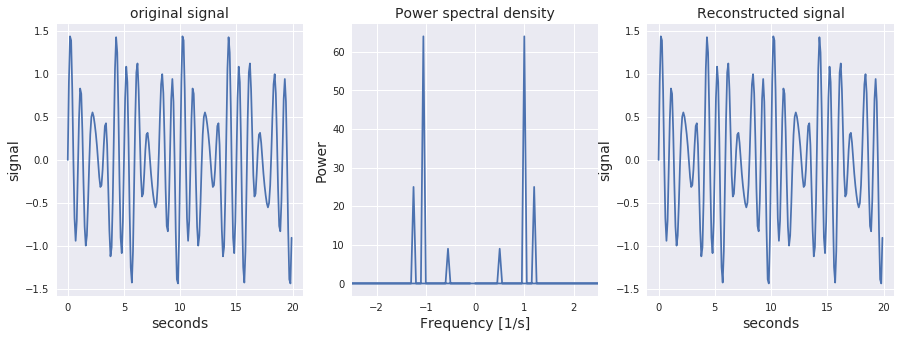

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
ax1.plot(t, samples)
ax1.set_xlabel("seconds", fontsize=14)
ax1.set_ylabel("signal", fontsize=14)
ax1.set_title("original signal", fontsize=14)

ax2.plot(f, PSD)
ax2.set_ylabel("Power", fontsize=14)
ax2.set_xlabel("Frequency [1/s]", fontsize=14)
ax2.set_xlim([-2.5, 2.5])
ax2.set_title("Power spectral density", fontsize=14)

ax3.plot(t, y_fit)
ax3.set_xlabel("seconds", fontsize=14)
ax3.set_ylabel("signal", fontsize=14)
ax3.set_title("Reconstructed signal", fontsize=14)
plt.show()

### Sample rate and noise

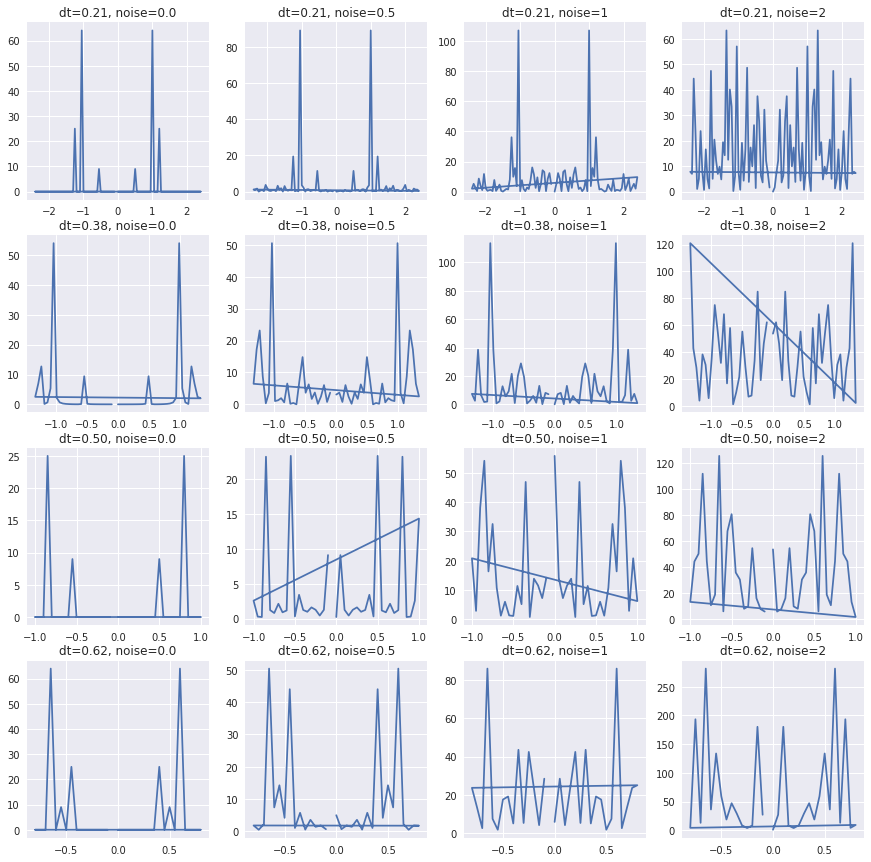

In [7]:
# Creating signal
frequencies = [0.5, 1.0, 1.2] # [1/s]
weights = [0.3, 0.8, 0.5]
signal = Signal(frequencies, weights)

# Sampling rates 
nyquist_freq = 2*np.amax(frequencies)
sample_rates = np.array([0.5, 0.9, 1.2, 1.5])*(1/nyquist_freq)
noise_levels = [0.000, 0.5, 1, 2]

fig, ax = plt.subplots(len(sample_rates),len(noise_levels),figsize=(15,15))
a = np.arange(len(sample_rates))
b = np.arange(len(noise_levels))
axis_index = list(itertools.product(a, b))

plot_index = 0 
fft_list = []
for dt in sample_rates:
    for sigma in noise_levels:
        axis = ax[axis_index[plot_index]]
        t = np.arange(0,20,dt)
        samples = signal.sample(t, noise=sigma)
        N = len(samples)
        y_fft = fft(samples, n=N)
        PSD = np.absolute(y_fft)**2*dt**2
        # Save signals 
        fft_list.append(y_fft)
        # from k to f_k, check help(fft) 
        f = np.concatenate([1/(dt*N)*np.arange(N/2+1), (np.arange(N/2-1)-N/2)/(dt*N)], axis=0)
        axis.plot(f, PSD)
        axis.set_title("dt="+"{0:.2f}".format(dt)+", noise="+str(sigma))
        #axis.set_xlim([-2.5, 2.5])
        plot_index += 1
plt.show()

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


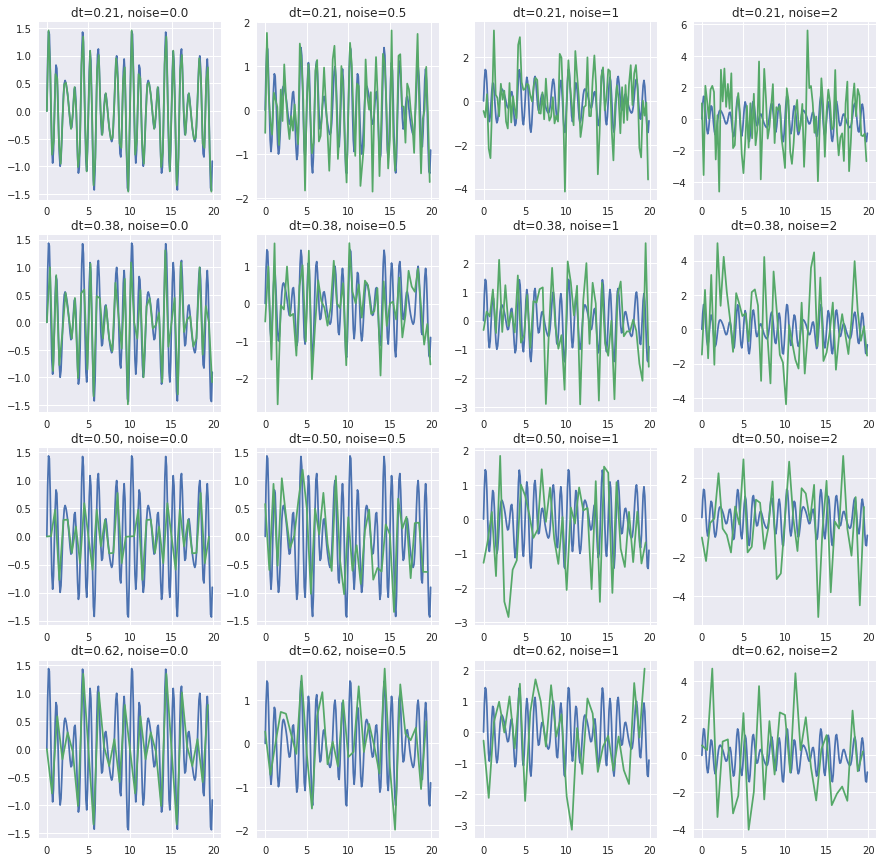

In [8]:
# Reconstructing signal with different sampling rate and noise
fig, ax = plt.subplots(len(sample_rates),len(noise_levels),figsize=(15,15))
a = np.arange(len(sample_rates))
b = np.arange(len(noise_levels))
axis_index = list(itertools.product(a, b))
orig_t = np.arange(0,20,0.1)
orig_samples = signal.sample(orig_t)

plot_index = 0 
for dt in sample_rates:
    for sigma in noise_levels:
        axis = ax[axis_index[plot_index]]
        t = np.arange(0,20,dt)
        y_fit = ifft(fft_list[plot_index])
        axis.plot(orig_t, orig_samples)
        axis.plot(t, y_fit)
        axis.set_title("dt="+"{0:.2f}".format(dt)+", noise="+str(sigma))
        #axis.set_xlim([-2.5, 2.5])
        plot_index += 1
plt.show()

# Notebook by Jake Vanderplas

Source [here](http://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/)

# Fast Lomb-Scargle Periodograms in Python

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->

<div style="float: right; margin-top: 10px; margin-bottom: 50px; width: 280px; height: 240px; margin: 10px;">
<center>
<a href="http://www.astroml.org/_images/fig_LS_example_1.png"><img src="http://www.astroml.org/_images/fig_LS_example_1.png"></a>
<small>Image source: astroML. Source code [here](http://www.astroml.org/book_figures/chapter10/fig_LS_example.html#book-fig-chapter10-fig-ls-example)</small>
</center>
</div>

*Edit, Summer 2016: All of the implementations discussed below have been added to [AstroPy](http://astropy.org) as of Version 1.2, along with logic to choose the optimal implementation automatically. Read more here: [``astropy.stats.LombScargle``](http://astropy.readthedocs.io/en/latest/stats/lombscargle.html).*

The Lomb-Scargle periodogram (named for [Lomb (1976)](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L) and [Scargle (1982)](http://adsabs.harvard.edu/abs/1982ApJ...263..835S)) is a classic method for finding periodicity in irregularly-sampled data.
It is in many ways analogous to the more familiar Fourier Power Spectral Density (PSD) often used for detecting periodicity in regularly-sampled data.

Despite the importance of this method, until recently there have not been any (in my opinion) solid implementations of the algorithm available for easy use in Python.
That has changed with the introduction of the [gatspy](http://astroml.org/gatspy/) package, which I recently released.
In this post, I will compare several available Python implementations of the Lomb-Scargle periodogram, and discuss some of the considerations required when using it to analyze data.

To cut to the chase, I'd recommend using the [gatspy](http://astroml.org/gatspy/) package for Lomb-Scargle periodograms in Python, and particularly its ``gatspy.periodic.LombScargleFast`` algorithm which implements an efficient pure-Python version of Press & Rybicki's $O[N\log N]$ periodogram.
Below, I'll dive into the reasons for this recommendation.

<!-- PELICAN_END_SUMMARY -->

## Example: Lomb-Scargle on Variable Stars

As an motivation, let's briefly consider some data from my own field: observations of an [*RR Lyrae-type*](https://en.wikipedia.org/wiki/RR_Lyrae_variable) variable star.
RR Lyrae are small stars – about 50% the mass of our sun – which pulsate with a regular period on order half a day.
Their relatively consistent peak intrinsic brightness allows for an accurate estimation of their distance from the sun, and thus they are important for studies such as [understanding the substructure](http://www.mpia.de/~bsesar/media.html) of the Milky Way galaxy.
Because of this and other similar applications, detecting the telltale periodic variation of RR Lyrae stars within noisy data is an important statistical task for astronomers.

Here we will quickly demonstrate what this looks like in practice, using tools from the [astroML](http://astroML.org) package to download some data, and tools from the [gatspy](http://astroml.org/gatspy/) package to detect the periodicity.

We'll start with some typical Python import statements:

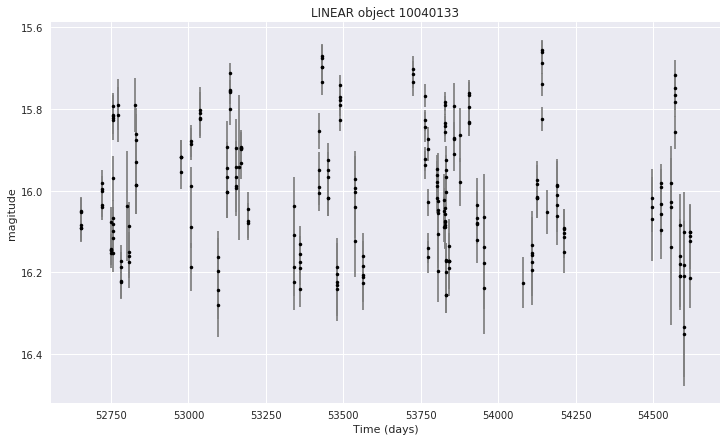

In [9]:
from astroML.datasets import fetch_LINEAR_sample
LINEAR_data = fetch_LINEAR_sample()
star_id = 10040133
t, mag, dmag = LINEAR_data.get_light_curve(star_id).T

fig, ax = plt.subplots(figsize=(12,7))
ax.errorbar(t, mag, dmag, fmt='.k', ecolor='gray')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(star_id))
ax.invert_yaxis();

This data has around 250 observations spread across about 2000 days, and we're hoping to detect a period of order 0.5 days.
If the series were regularly-sampled, we'd be far above the Nyquist limit and all hope would be lost.
Fortunately for astronomers, the assumptions behind the Nyquist sampling limit do not hold for irregular sampling rates, and we can proceed with no problem.

Let's start by computing and plotting the Lomb-Scargle Periodogram for this data, using tools from gatspy:

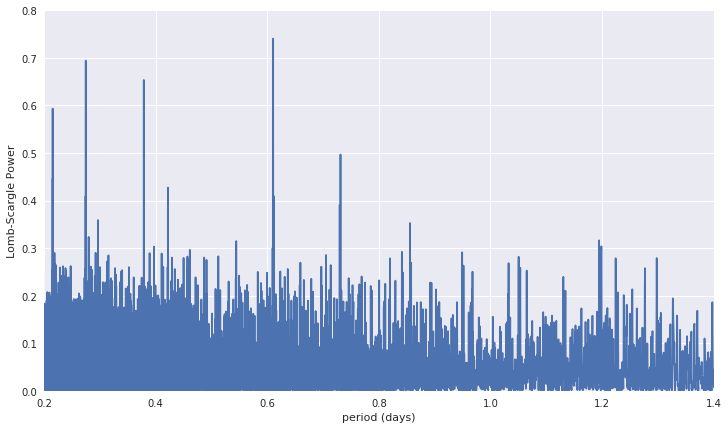

In [10]:
from gatspy.periodic import LombScargleFast
model = LombScargleFast()
model.fit(t, mag, dmag)
periods, power = model.periodogram_auto(nyquist_factor=100, oversampling=5)

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(periods, power)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

In [19]:
help(model.periodogram_auto)

Help on method periodogram_auto in module gatspy.periodic.modeler:

periodogram_auto(oversampling=5, nyquist_factor=3, return_periods=True) method of gatspy.periodic.lomb_scargle_fast.LombScargleFast instance
    Compute the periodogram on an automatically-determined grid
    
    This function uses heuristic arguments to choose a suitable frequency
    grid for the data. Note that depending on the data window function,
    the model may be sensitive to periodicity at higher frequencies than
    this function returns!
    
    The final number of frequencies will be
    Nf = oversampling * nyquist_factor * len(t) / 2
    
    Parameters
    ----------
    oversampling : float
        the number of samples per approximate peak width
    nyquist_factor : float
        the highest frequency, in units of the nyquist frequency for points
        spread uniformly through the data range.
    
    Returns
    -------
    period : ndarray
        the grid of periods
    power : ndarray
        

The periodogram gives a measure of periodic content as a function of period; we see here a strong peak at around 0.61 days.
Other lower peaks are due to some combination of higher-order harmonics in the data and effects of the irregular survey window.
While we could find this maximum manually from the above grid, ``gatspy`` provides a better way: a built-in two-stage grid-search that accurately determines the best period in a specified range:

In [11]:
# set range and find period
model.optimizer.period_range=(0.2, 1.4)
period = model.best_period
print("period = {0}".format(period))

Finding optimal frequency:
 - Estimated peak width = 0.0032
 - Using 5 steps per peak; omega_step = 0.00064
 - User-specified period range:  0.2 to 1.4
 - Computing periods at 42104 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 0.6105387801103276


We see that the optimizer determined that it needed a grid of over 40,000 points to adequately cover the frequency grid (more on this below), and in the end arrived at a best period of 0.6105 days.
Given this detected period, we can fold the input data and over-plot a best-fit empirical RR Lyrae template to see the fit:

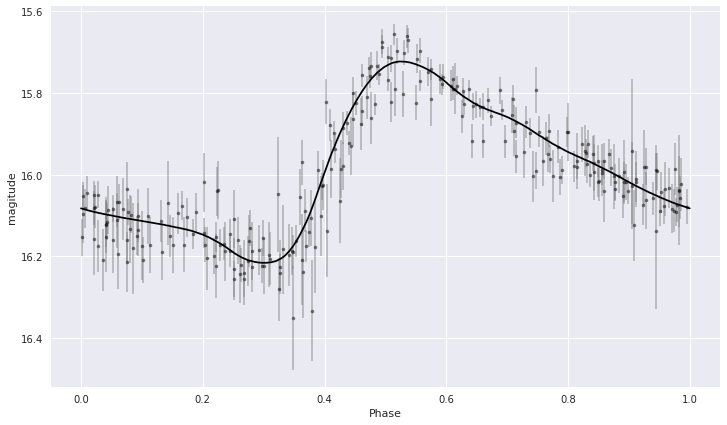

In [12]:
# Compute phases of the obsevations
phase = (t / period) % 1

# Compute best-fit RR Lyrae template
from gatspy.periodic import RRLyraeTemplateModeler
model = RRLyraeTemplateModeler('r').fit(t, mag, dmag)
phase_fit = np.linspace(0, 1, 1000)
mag_fit = model.predict(period * phase_fit, period=period)

# Plot the phased data & model
fig, ax = plt.subplots(figsize=(12,7))
ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
ax.plot(phase_fit, mag_fit, '-k')
ax.set(xlabel='Phase', ylabel='magitude')
ax.invert_yaxis();

## Computational Considerations for Lomb-Scargle

The Lomb-Scargle periodogram involves the computation of a power $P(\omega)$ at a set of frequencies $\omega_i$.
For data $\{y_k\}$ pre-centered such that $\sum_k y_k = 0$, the expression for the power is:

$$
P(\omega) \propto
  \frac{\left[\sum_k y_k \cos\omega(t_k - \tau)\right]^2}
    {\sum_k \cos^2\omega(t_k - \tau)} +
  \frac{\left[\sum_k y_k \sin\omega(t_k - \tau)\right]^2}
    {\sum_k \sin^2\omega(t_k - \tau)}
$$

where $\tau$ is an easily computed time-offset which orthogonalizes the model and makes $P(\omega)$ independent of a translation in $t$.

Rather than get lost in the math, I want to emphasize the key feature of this expression: **for any frequency $\omega$, the power is an $O[N]$ computation involving simple trigonometric sums over the data,** where $N$ is the number of observed data points.
The main computational question then becomes: how many frequencies must you compute?
In my experience, the most common mistake people make when doing this sort of periodic analysis is not thinking hard enough about the frequency grid.
It turns out that the grid-spacing question is *very* important.
If you choose too fine a grid, you do much more computation than is required.
Worse, if you choose too coarse a grid, the periodogram peak may fall between grid points and you'll miss it entirely!

Let's think about the required frequency range and frequency spacing for Lomb-Scargle.

### Frequency spacing

First we'll choose the spacing of the frequency grid.
If you're asking about a candidate frequency $f$, then data with range $T = t_{max} - t_{min}$ contains $T \cdot f$ complete cycles. If our error in frequency is $\delta f$, then $T\cdot\delta f$ is the error in number of cycles between the endpoints of the data.
It's clear that this error must not be a significant fraction of a cycle, or the fit could be drastically affected.
This leads to an approximate grid-spacing criterion:

$$
T\cdot\delta f \ll 1
$$

Commonly, we'll choose some oversampling factor (say, 5) and use $\delta f = (5T)^{-1}$ as our frequency grid spacing.

### Frequency limits

Next, we need to choose the upper and lower limits of the frequency grid. On the low end, $f=0$ is suitable, but causes some numerical problems – we'll go one step away and use $\delta f$ as our minimum frequency.
But on the high end, we need to make a choice: what's the highest frequency we'd trust our data to be sensitive to?
At this point, many people are tempted to mis-apply the Nyquist-Shannon sampling theorem, and choose some version of the Nyquist limit for the data (based on, say, the minimum or mean spacing between observations).
But this is entirely wrong! The Nyquist frequency is derived from special properties of regularly-sampled data, and does not apply – even approximately – to irregularly-sampled time-series.
In fact, as we saw above, irregularly-sampled data can be sensitive to much, much higher frequencies than even the minimum spacing between observations.
With this in mind, the upper limit for frequencies should be determined based on **what kind of signal you are looking for.**

Still, a common (if dubious) rule-of-thumb is that the high frequency is some multiple of what Press & Rybicki call the "average" Nyquist frequency,

$$
\hat{f}_{Ny} = \frac{N}{2T}
$$

This means that the "typical" number of frequencies you'll need is

$$
N_{freq} \sim O\left[\frac{\hat{f}_{Ny}}{\delta f}\right] \sim O\left[\frac{N/(2T)}{1/T}\right] \sim O[N]
$$

That is, the number of frequencies to search will scale with the number of data points!

### Computational Complexity

From the above considerations, we see that the determination of the optimal Lomb-Scargle period within $N$ points requires computing an $O[N]$ expression for power across $O[N]$ grid points; that is, Lomb-Scargle is naively an $O[N^2]$ algorithm.

This computational complexity can be improved in one of several ways.
Most notably, in a [1989 paper](http://adsabs.harvard.edu/full/1989ApJ...338..277P), Press and Rybicki proposed a clever method whereby a Fast Fourier Transform is used on a grid *extirpolated* from the original data, such that this naively $O[N^2]$ problem can be solved in $O[N\log N]$ time.
The broad idea is that when you compute sums of sines and cosines for one frequency, this gives you some amount of information about those sums computed at another frequency, and by carefully using all information across a frequency grid, you can significantly reduce the number of required operations.

Thus the fundamental divide between Lomb-Scargle implementations is whether they use the naive $O[N^2]$ algorithm or the $O[N\log N]$ algorithm of Press & Rybicki and other similar approaches.

## Lomb-Scargle Algorithms in Python

Now we get to the meat of this post: Lomb-Scargle implementations written in Python.
If you search this on Google, you'll currently find links to several available implementations.
Here I'm going to delve into and compare the following four implementations:

- ``scipy.signal.lombscargle``, an $O[N^2]$ implementation from [SciPy](http://docs.scipy.org/doc/scipy/reference/).
- ``astroML.time_series.lomb_scargle``, an $O[N^2]$ implementation from [astroML](http://astroML.org/).
- ``gatspy.periodic.LombScargle``, an $O[N^2]$ implementation from [gatspy](http://astroml.org/gatspy/).
- ``gatspy.periodic.LombScargleFast``, an $O[N\log N]$ implementation, also from [gatspy](http://astroml.org/gatspy/).

## False alarm probability based on bootstrap
### Source [here](http://ada7.cosmostat.org/ADA7_proceeding_MSuveges2.pdf) and [here](https://arxiv.org/pdf/0711.0330.pdf)

Assessment of the statistical significance of an eventual peak involves testing of the zero
hypothesis $H_{0}$ of the observed time series being purely white noise against the alternative, $H_{1}$,
stating that there is a periodic deterministic signal in it. We do this either by computing the
probability of a peak of the observed height or higher under $H_{0}$ (the false alarm probability or
FAP), or by computing levels corresponding to prescribed FAP values under $H_{0}$. Let's say we know the distribution of maximum values for a periodogram coming from a white noise signal, denoted by $f(z)$, then $FAP = 1-F(z)$ where $F(z)$ is the cumulative distribution of $f(z)$.

In this example, we will estimate $f(z)$ numerically using the bootstrap approach

### Step 1:
Create bootstrap repetitions by shuffling the values of the light curve but preserving time of observations. Non-parametric bootstrap uses the empirical distribution function of the observation as sampling distribution and does not force pre-specified distribution of the data. The result is a white noise sequence which corresponds to $H_{0}$. However, bootstrap breaks temporal dependencies, in order to avoid this, check [block bootstrap](https://nccur.lib.nccu.edu.tw/bitstream/140.119/35143/6/51007106.pdf) which mix the values of the light curves by blocks and preserves part of the time dependency.

In [13]:
# Step 1
star_id = 10040133
t, mag, dmag = LINEAR_data.get_light_curve(star_id).T

R_bootstrap = 2000
bootstraps = []
for i in range(R_bootstrap):
    shuffled_index = np.arange(len(t))
    np.random.shuffle(shuffled_index)
    bootstraps.append([mag[shuffled_index], dmag[shuffled_index]])

### Step 2:
For each bootstrap, compute the periodogram and store the peak. In [this paper](http://ada7.cosmostat.org/ADA7_proceeding_MSuveges2.pdf), the author shows a faster method to compute the peaks for each bootstrap. Basically, they subsample the frequencies where the periodogram is calculated and take the maximum peak of those subsamples (under certain conditions).

In [14]:
# Step 2
start = time.time()
periodogram_max = []
for i, [mag, dmag] in enumerate(bootstraps):
    print (i, end="\r")
    model = LombScargleFast()
    model.fit(t, mag, dmag)
    periods, power = model.periodogram_auto(nyquist_factor=100, oversampling=5)
    max_p = np.argmax(power)
    periodogram_max.append(periods[np.argmax(power)])
end = time.time()
print("elapsed time: "+str(end-start))

elapsed time: 658.3498570919037


### Step 3:
Take the histogram of peaks as the distribution. It is possible to fit a distribution in order to extrapolate the integration for the cumulative distribution, as they do [here](http://ada7.cosmostat.org/ADA7_proceeding_MSuveges2.pdf). Then we compute the cumulative distribution $F(z)$ and the $FAP$

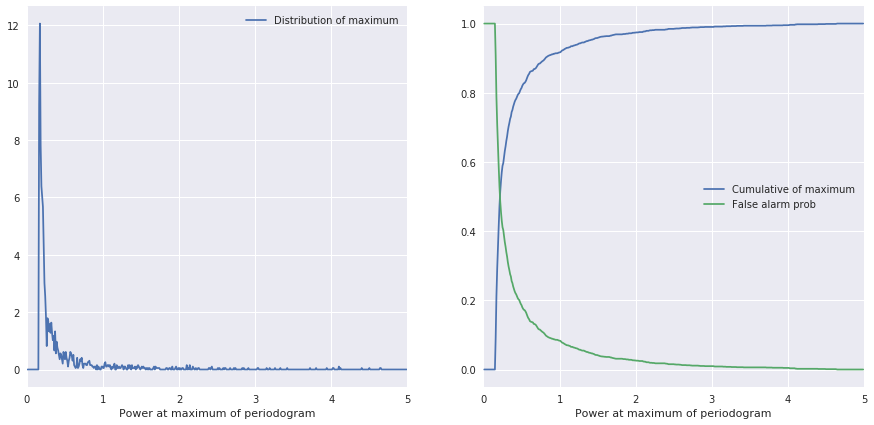

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

bins = np.arange(0,5,step=0.01)
hist, bins = np.histogram(periodogram_max, bins=bins, density=True)
cumulative = np.cumsum(hist)*0.01
false_alarm_prob = 1 - cumulative

ax1.plot(bins[1:], hist, label="Distribution of maximum")
ax2.plot(bins[1:], cumulative, label="Cumulative of maximum")
ax2.plot(bins[1:], false_alarm_prob, label="False alarm prob")
ax1.set_xlim([np.amin(bins), 5])
ax1.set
ax1.set_xlabel("Power at maximum of periodogram")
ax2.set_xlim([np.amin(bins), 5])
ax2.set_xlabel("Power at maximum of periodogram")
ax1.legend()
ax2.legend()
plt.show()

### Step 4:
Specify a level of confidence for FAP and find the necessary power of a peak in order to consider it as a real one (that comes from hypothesis $H_{1}$)

In [16]:
confidence = [0.2, 0.15, 0.1]
power_values = []
for c in confidence:
    power_values.append(bins[np.where(false_alarm_prob < c)[0]][0])

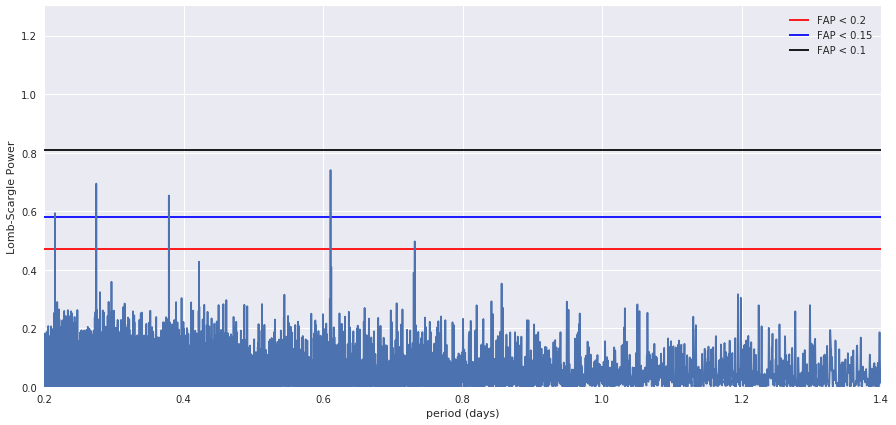

In [17]:
star_id = 10040133
t, mag, dmag = LINEAR_data.get_light_curve(star_id).T
model = LombScargleFast()
model.fit(t, mag, dmag)
periods, power = model.periodogram_auto(nyquist_factor=100, oversampling=5)
colors = ['r', 'b', 'k']
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(periods, power)
for i, values in enumerate(power_values):
    ax.hlines(values, xmin=0.2, xmax=1.4, colors=colors[i], label="FAP < "+str(confidence[i]))
ax.set(xlim=(0.2, 1.4), ylim=(0, 1.3),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power');
plt.legend()
plt.show()